# Experiment Main

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/w_final_context_shifted.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1397141, 219), 7701, (162189, 160), 79207)

In [5]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').unique().tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

---

## Replay

In [9]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, structure, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame()
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function

      here should be state_t * all_items
      '''
      state_tensor, state_t = get_input_tensor(state_t, current_stream, with_tensor=True)
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)

      reward_t = df_to_tensor(reward_t).view(len(reward_t), 1)

      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target = reward_t
      else:
        state_tp1, _ = get_input_tensor(state_tp1, next_stream, with_tensor=True)
        if target_net == None:
          with torch.no_grad():
            Q_sa = torch.max(eval_net(state_tp1))
        elif structure == 'target':
          with torch.no_grad():
            Q_sa = torch.max(target_net(state_tp1))
        elif structure == 'double':
          with torch.no_grad():
            _, selected_actions = eval_net(state_tp1).max(dim=0, keepdim=True)
            Q_sa = target_net(state_tp1).gather(dim=0, index=selected_actions)
          
        # r + gamma * max Q(s',a')
        # current_target = reward_t + self.discount * Q_sa
        current_target = reward_t.add(Q_sa, alpha=self.discount)

      targets = torch.cat((targets, current_target), 0)
    return inputs, targets

## Epsilon

In [10]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data, delta):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, delta):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    # epoch = data
    # self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [15]:
class DQN(object):
  def __init__(self, structure, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold, single_reward):
    self.eval_net = Net()
    self.target_net = Net() if not structure == 'vanilla' else None
    self.structure = structure
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.single_reward = single_reward
    self.hist = []
    self.rec_list = []
    self.ep_score_list = []
    self.current_user_hit_list = [] # current_asid's hit actions
    self.all_hit_list = [] # all asids' hist actions, asid actual buy lenght
    self.avg_hit_list = [] # avg hit/all list
    self.exploit_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = []
    for a, b, c in zip(real_bought_ids_series, self.action_ids, self.action_ids.index):
      reward_list.append(a & b)
      if a & b: self.current_user_hit_list.append(c)
      
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    # return list(map(lambda x: x * sum(reward_list), reward_list))
    if self.single_reward:
      return pd.Series(reward_list, index=self.stream_items)
    else:
      return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(self.asid):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    if self.target_net:
      self.target_net.to(DEVICE)
    self.eval_net.train(True)
    self.epsilon.clear()

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0
      self.explore = 0
      self.exploit = 0

      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.user_all_streams.loc[stream]
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          # Calculate score for each users
          if game_over:
            self.all_hit_list.append([len(set(self.current_user_hit_list)), len(BOUGHT_DICT[self.asid])])
            self.current_user_hit_list = []

          next_state = self.user_all_streams.loc[self.stream_list[i + 1]] if not game_over else []
          next_stream = None if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          if sum(reward) > 0 or len(self.exp_replay.memory) < 10:
            self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)
          self.learn_step_counter += 1
          if self.target_net and (self.learn_step_counter % self.switch_param_threshold == 0):
            self.target_net.load_state_dict(self.eval_net.state_dict())


          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, self.structure, batch_size=self.batch_size)
          inputs = df_to_tensor(inputs)
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(self.asid, (new_Q - old_Q), len(self.stream_items))
          
      self.epsilon.update_at_epoch(e)

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)
      self.exploit_list.append(self.exploit)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss:.2f} | Epoch Hit Rate {(self.win_cnt/self.rec_cnt):.2f} | \
Cumulative Hit Rate {(sum(self.hist)/sum(self.rec_list)):.2f} | Explore {self.explore} | Exploit {self.exploit} | \
Score {self.ep_score} | Rec_cnt: {self.rec_cnt}')
      start = e * 100
      end = start + 100
      hit = [a[0] for a in self.all_hit_list[start:end]]
      bought = [a[1] for a in self.all_hit_list[start:end]]
      print(sum(hit)/sum(bought))
      self.avg_hit_list.append(sum(hit)/sum(bought))

## Main Method

In [12]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-3
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

## Exp: Reward Setting

In [ ]:
'''
EPS_target_rsum_x_positive

- VDBE(0.5, 0.01)
- Decay(0.5, 0.85)
'''

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.99, 0.92)
EPS_target_rsum_x_positive = DQN('target', exp_replay, epsilon, 
                                  NUM_EPISODE, EPOCH, BATCH_SIZE, 
                                  LR, SWITCH_PARAM_THRESHOLD, single_reward=False)
EPS_target_rsum_x_positive.train()

Epoch 0 started.   Time: 22:40:23


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100 | Loss 815.83 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.50 | Explore 2311 | Exploit 36 | Score 1895 | Rec_cnt: 2347
0.19100346020761247
Epoch 1 started.   Time: 22:43:11


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss 593.25 | Epoch Hit Rate 0.46 | Cumulative Hit Rate 0.49 | Explore 1531 | Exploit 143 | Score 1108 | Rec_cnt: 1674
0.18541996830427893
Epoch 2 started.   Time: 22:45:12


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/100 | Loss 461.56 | Epoch Hit Rate 0.47 | Cumulative Hit Rate 0.48 | Explore 1501 | Exploit 292 | Score 1237 | Rec_cnt: 1793
0.18632422705709145
Epoch 3 started.   Time: 22:47:14


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/100 | Loss 427.89 | Epoch Hit Rate 0.51 | Cumulative Hit Rate 0.49 | Explore 1405 | Exploit 434 | Score 1345 | Rec_cnt: 1839
0.20914194065757818
Epoch 4 started.   Time: 22:49:29


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/100 | Loss 521.02 | Epoch Hit Rate 0.48 | Cumulative Hit Rate 0.49 | Explore 1191 | Exploit 503 | Score 1152 | Rec_cnt: 1694
0.18921813637986434
Epoch 5 started.   Time: 22:51:31


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/100 | Loss 287.54 | Epoch Hit Rate 0.47 | Cumulative Hit Rate 0.48 | Explore 1074 | Exploit 595 | Score 1123 | Rec_cnt: 1669
0.19370770074995428
Epoch 6 started.   Time: 22:53:37


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/100 | Loss 535.65 | Epoch Hit Rate 0.51 | Cumulative Hit Rate 0.49 | Explore 1335 | Exploit 937 | Score 1729 | Rec_cnt: 2272
0.19654242275625305
Epoch 7 started.   Time: 22:56:20


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/100 | Loss 368.15 | Epoch Hit Rate 0.48 | Cumulative Hit Rate 0.49 | Explore 804 | Exploit 690 | Score 1094 | Rec_cnt: 1494
0.16133744521993182
Epoch 8 started.   Time: 22:58:10


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/100 | Loss 405.67 | Epoch Hit Rate 0.47 | Cumulative Hit Rate 0.48 | Explore 977 | Exploit 939 | Score 1397 | Rec_cnt: 1916
0.19227846177230581
Epoch 9 started.   Time: 23:00:35


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/100 | Loss 424.29 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.49 | Explore 874 | Exploit 1086 | Score 1507 | Rec_cnt: 1960
0.18865113759479957
Epoch 10 started.   Time: 23:02:54


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/100 | Loss 355.10 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.49 | Explore 643 | Exploit 795 | Score 1100 | Rec_cnt: 1438
0.1927144535840188
Epoch 11 started.   Time: 23:04:42


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/100 | Loss 428.60 | Epoch Hit Rate 0.52 | Cumulative Hit Rate 0.49 | Explore 599 | Exploit 876 | Score 1259 | Rec_cnt: 1475
0.19361954861700323
Epoch 12 started.   Time: 23:06:36


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/100 | Loss 679.42 | Epoch Hit Rate 0.52 | Cumulative Hit Rate 0.49 | Explore 825 | Exploit 1430 | Score 1822 | Rec_cnt: 2255
0.20796822058651712
Epoch 13 started.   Time: 23:09:17


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/100 | Loss 336.65 | Epoch Hit Rate 0.49 | Cumulative Hit Rate 0.49 | Explore 454 | Exploit 901 | Score 1011 | Rec_cnt: 1355
0.18494623655913978
Epoch 14 started.   Time: 23:11:02


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/100 | Loss 350.54 | Epoch Hit Rate 0.53 | Cumulative Hit Rate 0.49 | Explore 525 | Exploit 1179 | Score 1469 | Rec_cnt: 1704
0.1448736998514116
Epoch 15 started.   Time: 23:13:10


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/100 | Loss 747.70 | Epoch Hit Rate 0.52 | Cumulative Hit Rate 0.50 | Explore 537 | Exploit 1343 | Score 1588 | Rec_cnt: 1880
0.1946853146853147
Epoch 16 started.   Time: 23:15:25


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/100 | Loss 416.71 | Epoch Hit Rate 0.49 | Cumulative Hit Rate 0.50 | Explore 478 | Exploit 1421 | Score 1255 | Rec_cnt: 1899
0.19010623117171396
Epoch 17 started.   Time: 23:17:38


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/100 | Loss 316.86 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.50 | Explore 439 | Exploit 1482 | Score 1527 | Rec_cnt: 1921
0.20406306852637962
Epoch 18 started.   Time: 23:19:54


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/100 | Loss 564.40 | Epoch Hit Rate 0.53 | Cumulative Hit Rate 0.50 | Explore 348 | Exploit 1239 | Score 1394 | Rec_cnt: 1587
0.21143375680580762
Epoch 19 started.   Time: 23:21:47


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/100 | Loss 854.65 | Epoch Hit Rate 0.52 | Cumulative Hit Rate 0.50 | Explore 415 | Exploit 1684 | Score 1733 | Rec_cnt: 2099
0.1860436137071651
Epoch 20 started.   Time: 23:24:27


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20/100 | Loss 383.03 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.50 | Explore 328 | Exploit 1513 | Score 1362 | Rec_cnt: 1841
0.21109498467989035
Epoch 21 started.   Time: 23:26:47


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21/100 | Loss 409.28 | Epoch Hit Rate 0.48 | Cumulative Hit Rate 0.50 | Explore 298 | Exploit 1403 | Score 1260 | Rec_cnt: 1701
0.1927710843373494
Epoch 22 started.   Time: 23:28:44


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22/100 | Loss 465.91 | Epoch Hit Rate 0.55 | Cumulative Hit Rate 0.50 | Explore 251 | Exploit 1419 | Score 1493 | Rec_cnt: 1670
0.20678320633497685
Epoch 23 started.   Time: 23:30:57


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23/100 | Loss 455.40 | Epoch Hit Rate 0.53 | Cumulative Hit Rate 0.50 | Explore 264 | Exploit 1566 | Score 1497 | Rec_cnt: 1830
0.17550968722299606
Epoch 24 started.   Time: 23:33:17


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24/100 | Loss 352.28 | Epoch Hit Rate 0.47 | Cumulative Hit Rate 0.50 | Explore 216 | Exploit 1551 | Score 1336 | Rec_cnt: 1767
0.16496232508073197
Epoch 25 started.   Time: 23:35:24


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25/100 | Loss 365.15 | Epoch Hit Rate 0.49 | Cumulative Hit Rate 0.50 | Explore 176 | Exploit 1411 | Score 1155 | Rec_cnt: 1587
0.2057605421686747
Epoch 26 started.   Time: 23:37:23


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26/100 | Loss 384.57 | Epoch Hit Rate 0.51 | Cumulative Hit Rate 0.50 | Explore 160 | Exploit 1490 | Score 1298 | Rec_cnt: 1650
0.19878997407087295
Epoch 27 started.   Time: 23:39:21


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27/100 | Loss 297.50 | Epoch Hit Rate 0.49 | Cumulative Hit Rate 0.50 | Explore 140 | Exploit 1303 | Score 1096 | Rec_cnt: 1443
0.18503862822687017
Epoch 28 started.   Time: 23:41:07


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28/100 | Loss 391.95 | Epoch Hit Rate 0.50 | Cumulative Hit Rate 0.50 | Explore 174 | Exploit 1624 | Score 1408 | Rec_cnt: 1798
0.1877627276973377
Epoch 29 started.   Time: 23:43:14


  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
hit = [a[0] for a in EPS_target_rsum_x_positive.all_hit_list]
bought = [a[1] for a in EPS_target_rsum_x_positive.all_hit_list]

In [23]:
sum(hit)/sum(bought)

0.17180196830242345

In [32]:
# baseline100 = pd.read_pickle('../Experiments Results/res_baseline_100_vanilla.pkl')

In [28]:
res = [a/b for a, b in zip(EPS_target_rsum_x_positive.ep_score_list, EPS_target_rsum_x_positive.rec_list)]
exploit_rate = [a/b for a, b in zip(EPS_target_rsum_x_positive.exploit_list, EPS_target_rsum_x_positive.rec_list)]

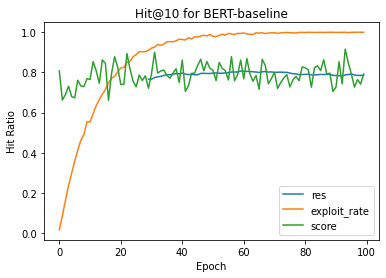

In [34]:
# plt.plot(EPS_target_rsum_x_positive.ep_score_list, label='hit')
# plt.plot(EPS_target_rsum_x_positive.avg_hit_list, label='res')
plt.plot(pd.Series(res).rolling(30).mean(), label='res')
plt.plot(exploit_rate, label='exploit_rate')
plt.plot(res, label='score')
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('Hit@10 for BERT-baseline')
# plt.ylim([0.4, 0.6])
plt.legend()

In [30]:
with open('../Models/EPS_target_rsum_x_positive-fix-exploit.pkl', 'wb') as file_pi:
  pickle.dump(EPS_target_rsum_x_positive, file_pi, pickle.HIGHEST_PROTOCOL)

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

In [135]:
asd = pd.read_pickle('../Models/EPS_target_rsum_x_positive.pkl')

In [139]:
asd.ep_score_list #== EPS_target_rsum_x_positive.ep_score_list

[1429,
 1331,
 1107,
 1384,
 1581,
 1417,
 1266,
 1208,
 1538,
 1726,
 1087,
 1487,
 1158,
 1706,
 1211,
 934,
 959,
 952,
 1082,
 1191,
 1549,
 1392,
 1580,
 1081,
 1220,
 1012,
 1067,
 1288,
 1340,
 1228,
 1297,
 1219,
 1172,
 1204,
 1596,
 1555,
 1287,
 1804,
 1126,
 1277,
 1195,
 1168,
 1309,
 1373,
 1365,
 1038,
 1642,
 1777,
 1431,
 951,
 1168,
 1355,
 1450,
 1470,
 1060,
 1498,
 1281,
 1264,
 1672,
 1039,
 1100,
 1139,
 1178,
 1001,
 1234,
 1372,
 1386,
 1352,
 1336,
 1334,
 1595,
 1301,
 1721,
 1343,
 1287,
 1607,
 1153,
 1316,
 1344,
 1157,
 1281,
 1172,
 924,
 1278,
 1302,
 1565,
 1168,
 1731,
 1470,
 1430,
 1441,
 1310,
 1022,
 1218,
 1037,
 1338,
 949,
 1385,
 1369,
 1412]